In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
input_data_path = 'data'
transactions = pd.read_csv(f'{input_data_path}/merged_data.csv')

In [3]:
transactions = transactions.drop(columns=['client_id', 'card_id', 'merchant_id',
'merchant_city']).set_index('transaction_id')

In [4]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['acct_open_date'] = pd.to_datetime(transactions['acct_open_date'])
transactions['expires'] = pd.to_datetime(transactions['expires'])

In [5]:
# select category and numerical columns
category_cols = transactions.select_dtypes(include=['object','bool']).columns.tolist()
numerical_cols = transactions.select_dtypes(include=['number']).columns

# Store target and its color legend
target_column = 'target'
target_colors = {0: "lightgrey", 1: "darkblue"}
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in target_colors.values()]
legend_labels = list(target_colors.keys())

In [6]:
transactions[category_cols] = transactions[category_cols].apply(lambda col: pd.Categorical(col))
transactions['target'] = pd.Categorical(transactions['target'])
category_cols = transactions.select_dtypes(include=['category']).columns.tolist()
numerical_cols = transactions.select_dtypes(include=['number']).columns
date_cols = transactions.select_dtypes(include=['datetime']).columns

In [10]:
transactions['target'] = transactions['target'].astype(int)
transactions['use_chip'] = transactions['use_chip'].astype(str)

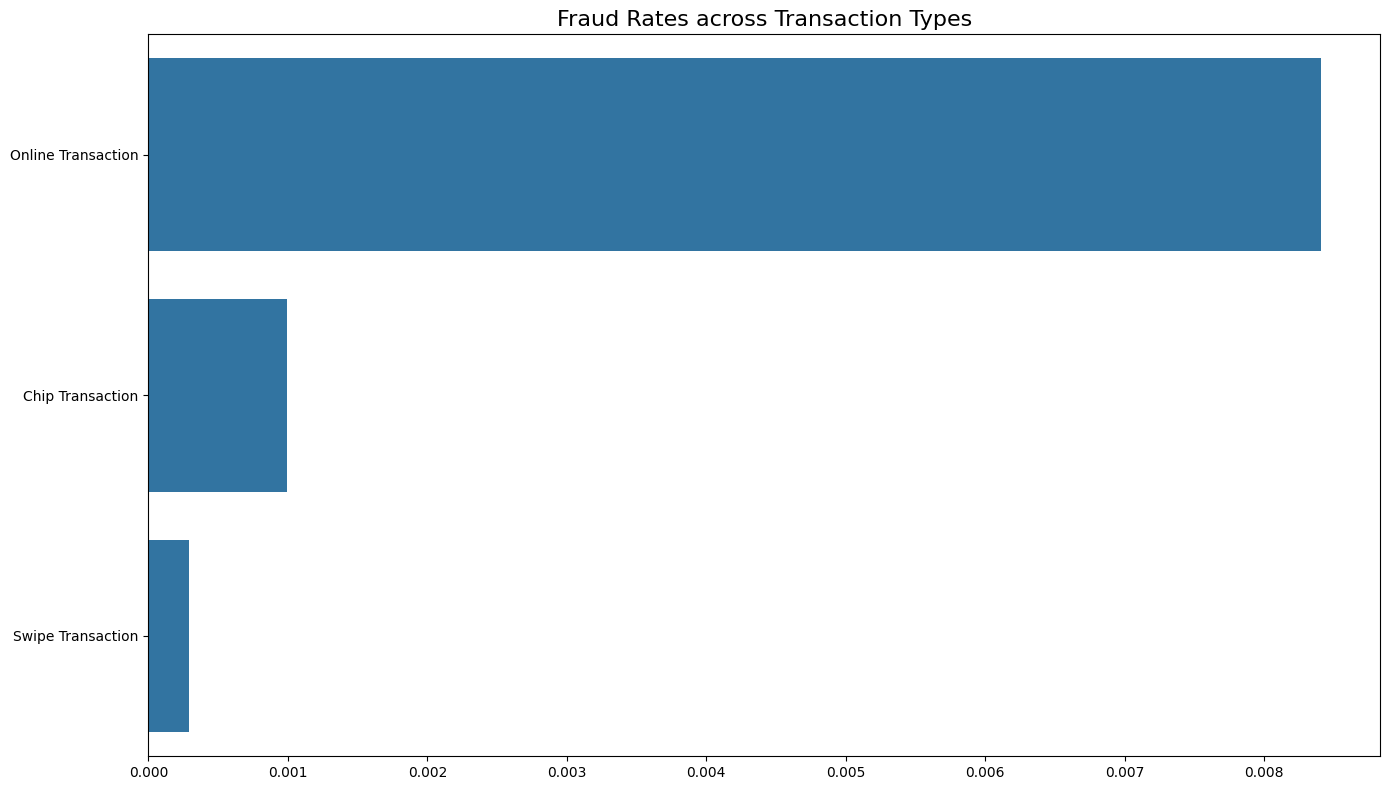

In [13]:
plt.figure(figsize=(14, 8))
mcc_fraud = transactions.groupby(['use_chip'])['target'].mean().reset_index()
mcc_fraud = mcc_fraud.sort_values('target', ascending=False).head(15)

ax = sns.barplot(x='target', y='use_chip', data=mcc_fraud)
plt.title('Fraud Rates across Transaction Types', fontsize=16)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(None)
plt.tight_layout()

plt.savefig('fraud rates across transaction types', dpi=600)

plt.show()  # Explicitly show the plot in the notebook

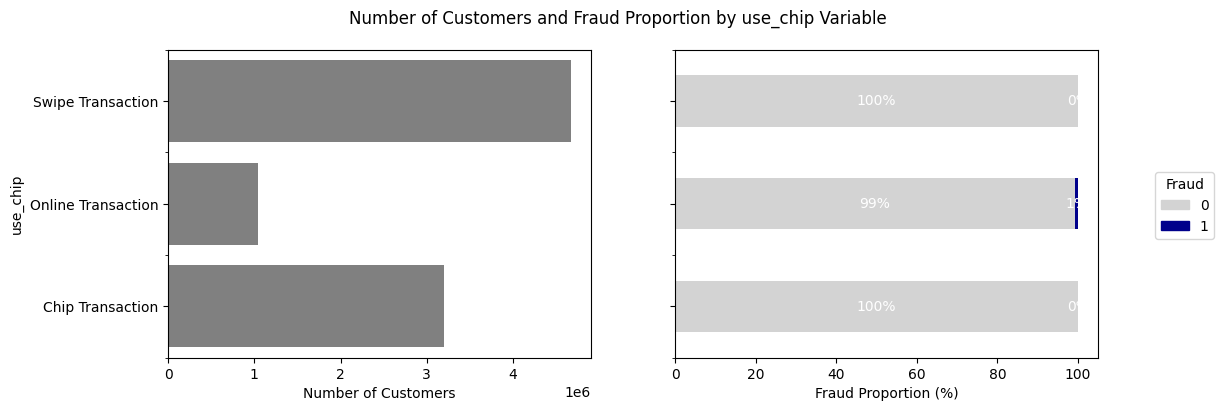

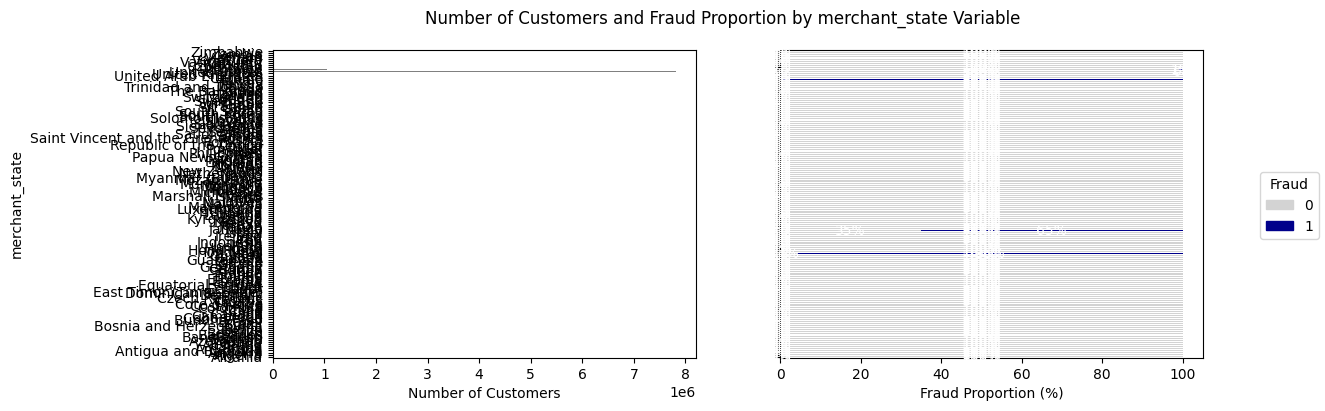

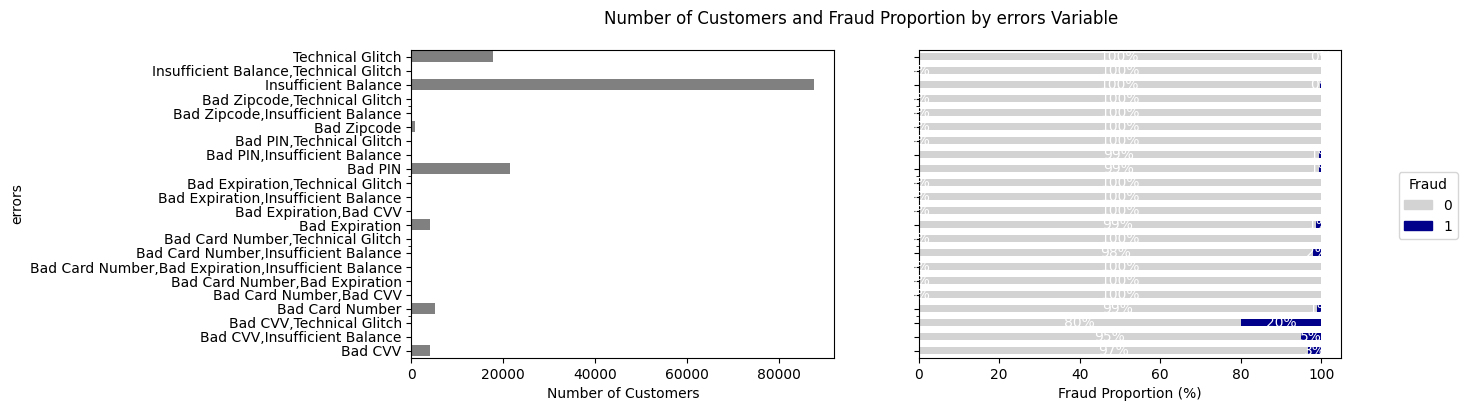

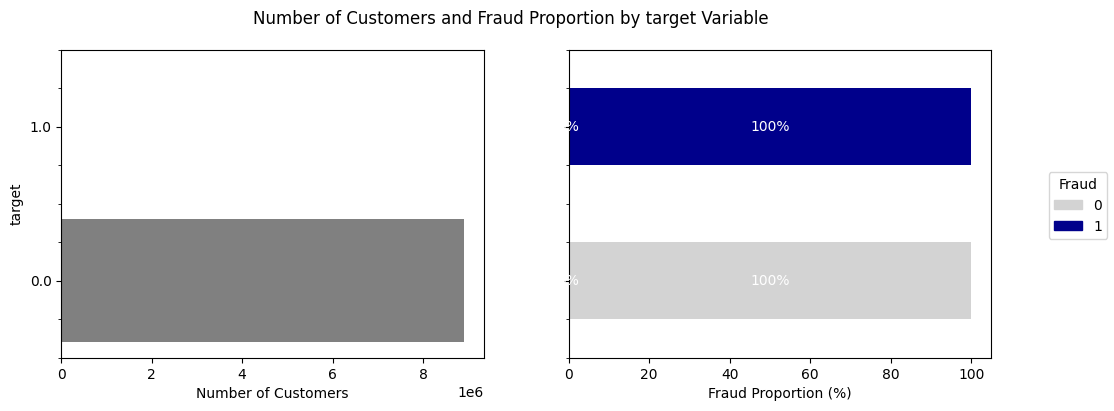

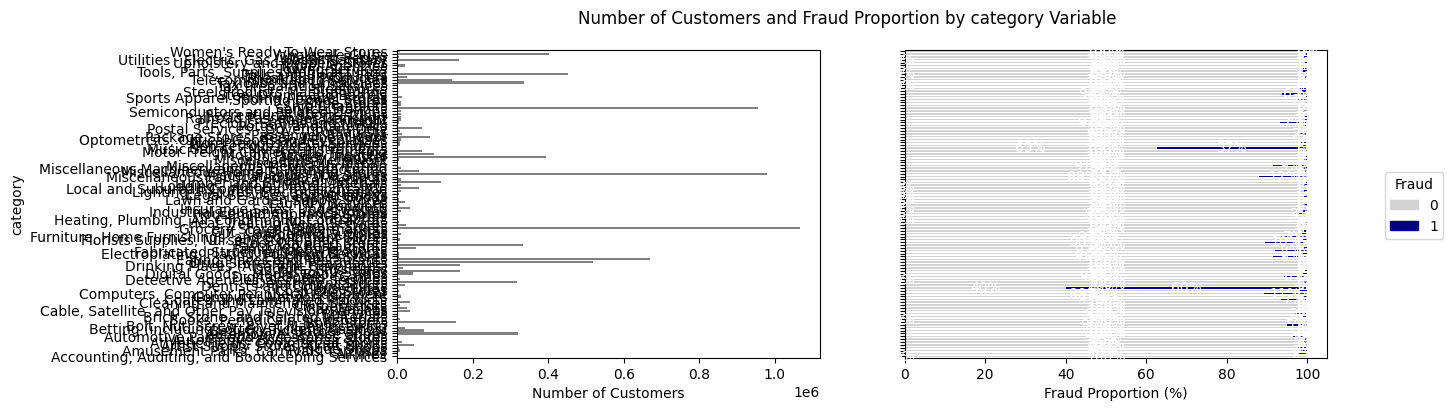

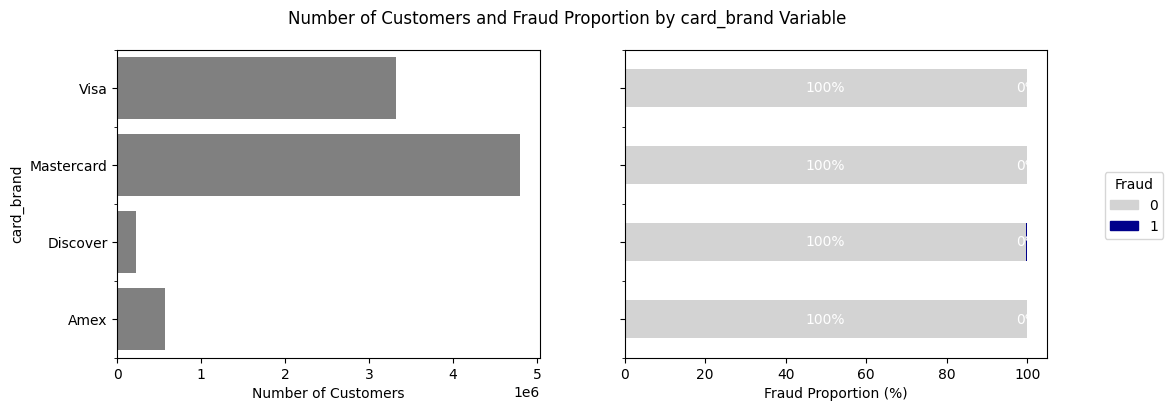

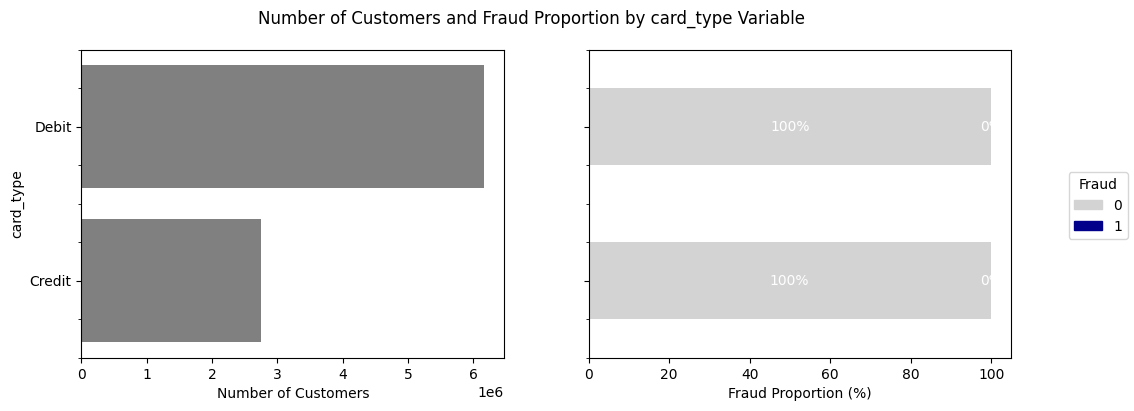

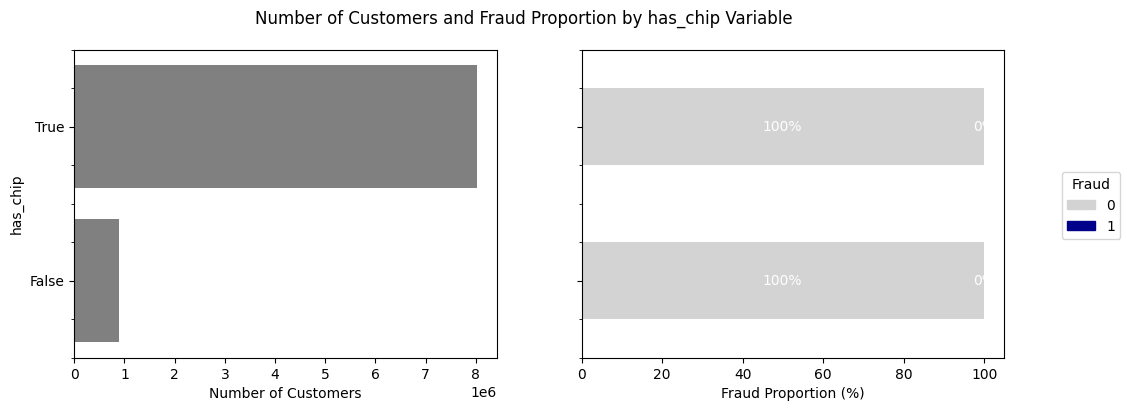

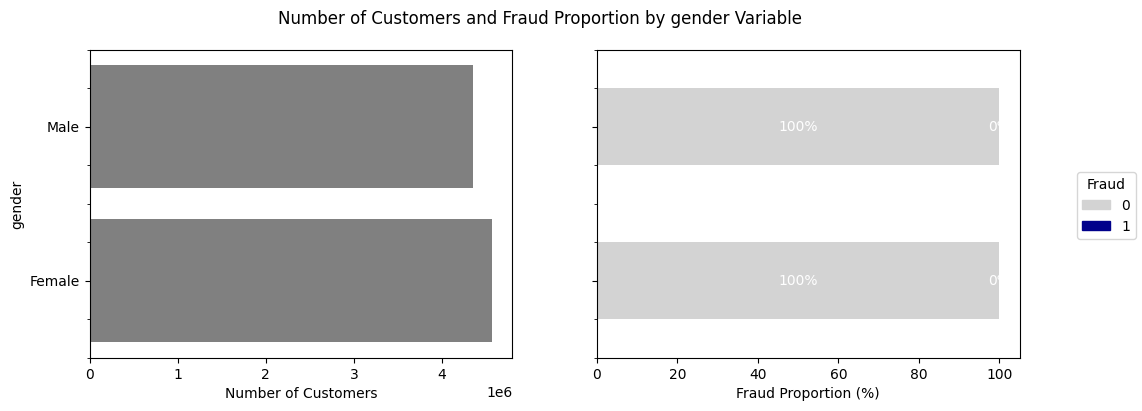

In [7]:
# for each category variable
for variable in category_cols:
    # set the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    fig.suptitle(f'Number of Customers and Fraud Proportion by {variable} Variable')

    # first plot - univariate frequency; include custom x-label
    sns.countplot(data=transactions, y=variable, ax=axes[0], color="grey")
    axes[0].set_xlabel('Number of Customers')

    # calculate the proportion of churn
    churn_counts = transactions.groupby([variable, target_column], observed=False).size().unstack()
    # Normalize to 100%
    churn_proportions = churn_counts.div(churn_counts.sum(axis=1)/100, axis=0)
    
    # second plot - churn proportion; include custom x-label
    churn_proportions.plot(kind='barh', stacked=True, ax=axes[1], 
                            color=[target_colors[col] for col in churn_proportions.columns], legend=False)
    axes[1].set_xlabel("Fraud Proportion (%)")
    
    # Add a single legend outside the plots (to the right) for the target legend
    fig.legend(legend_handles, legend_labels, title="Fraud", loc='center right')

    # Add labels inside the stacked bars
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt="%.0f%%", label_type="center", color='white', fontsize=10)

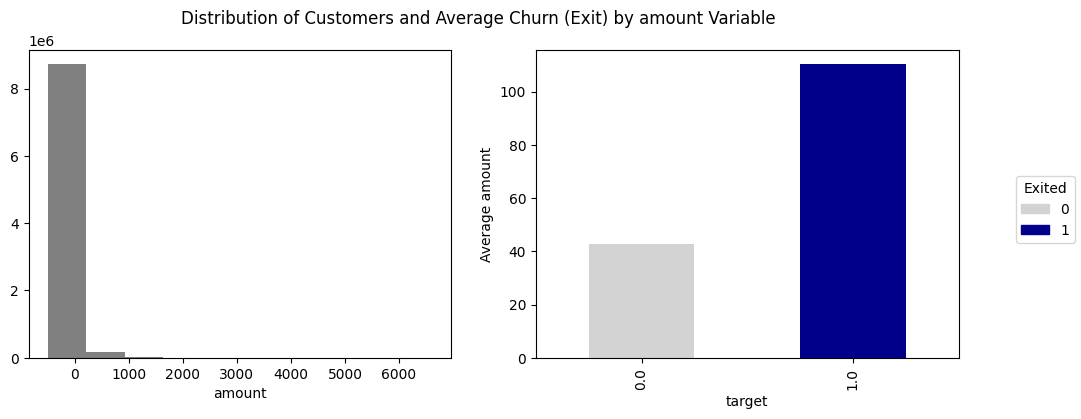

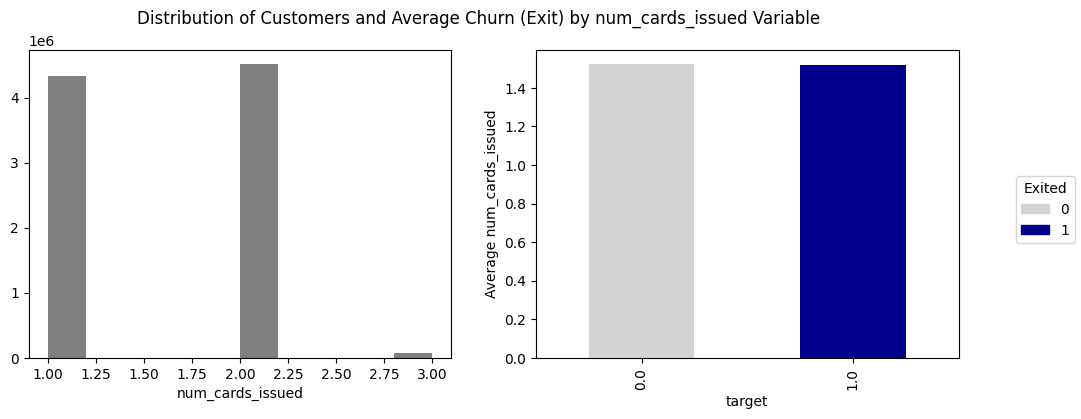

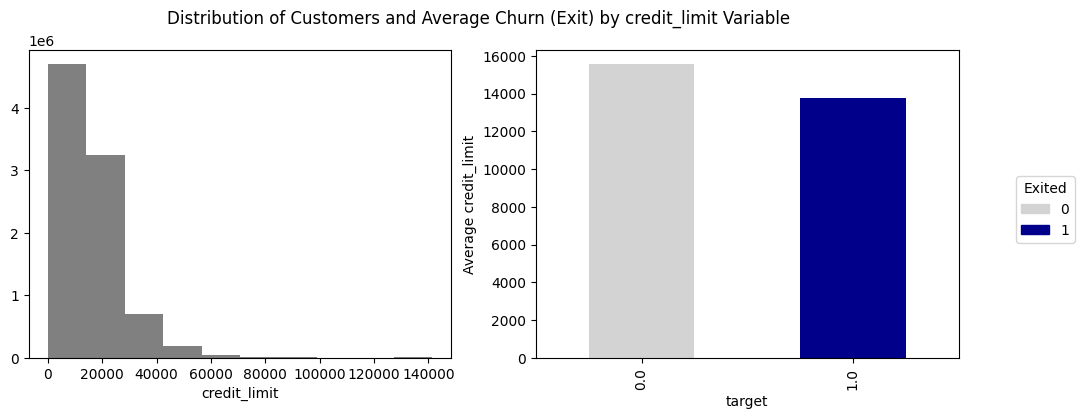

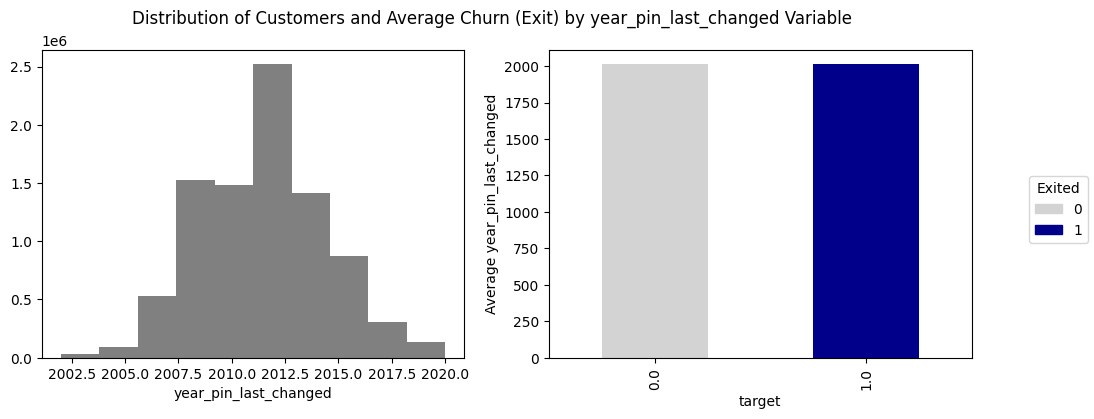

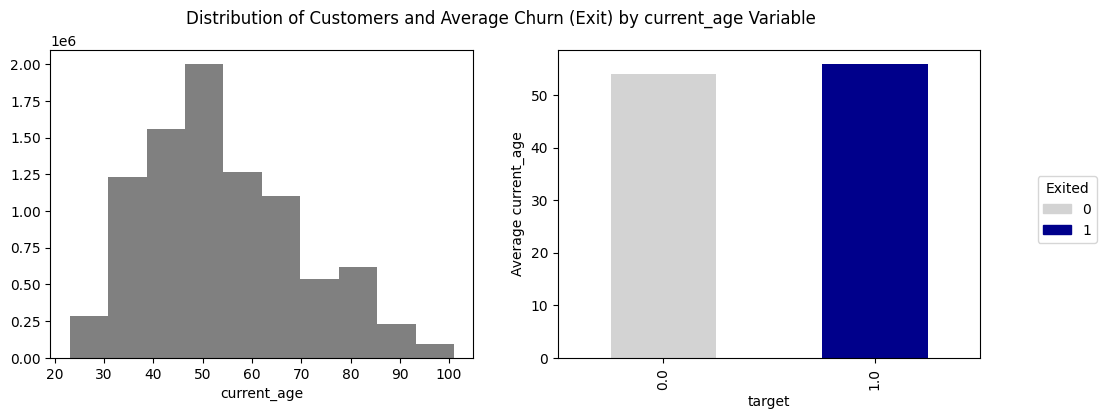

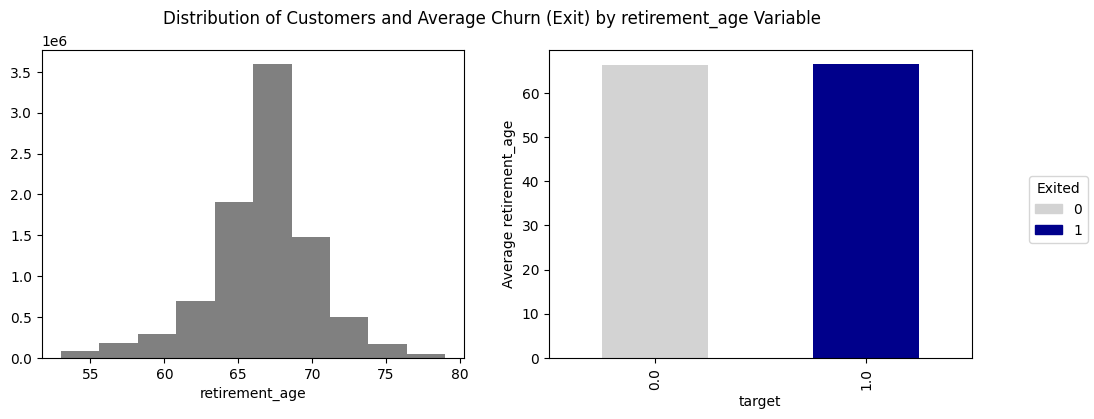

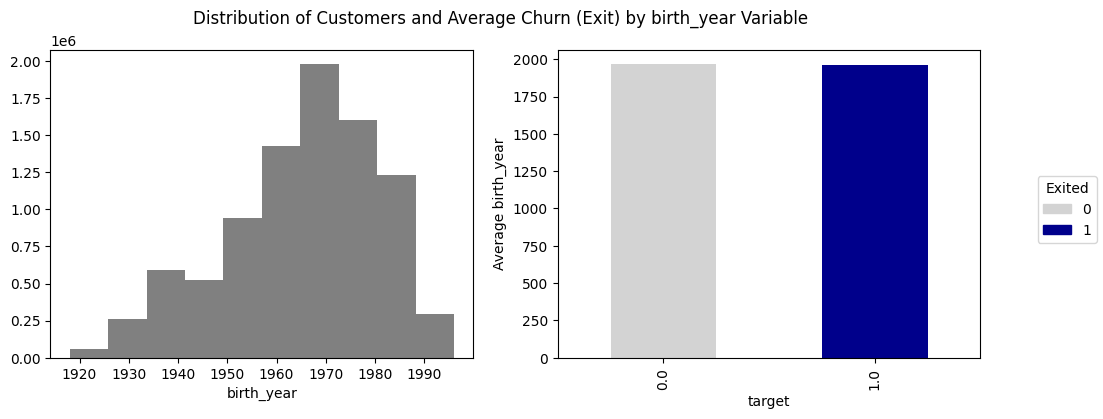

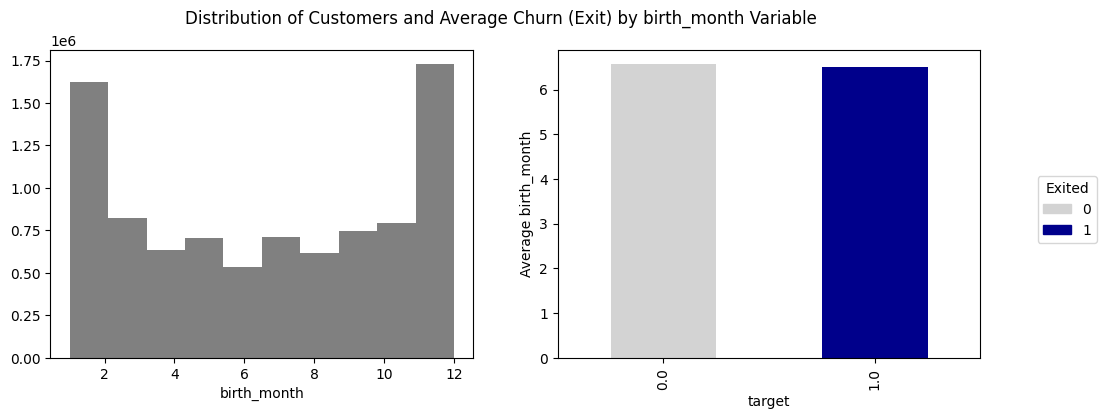

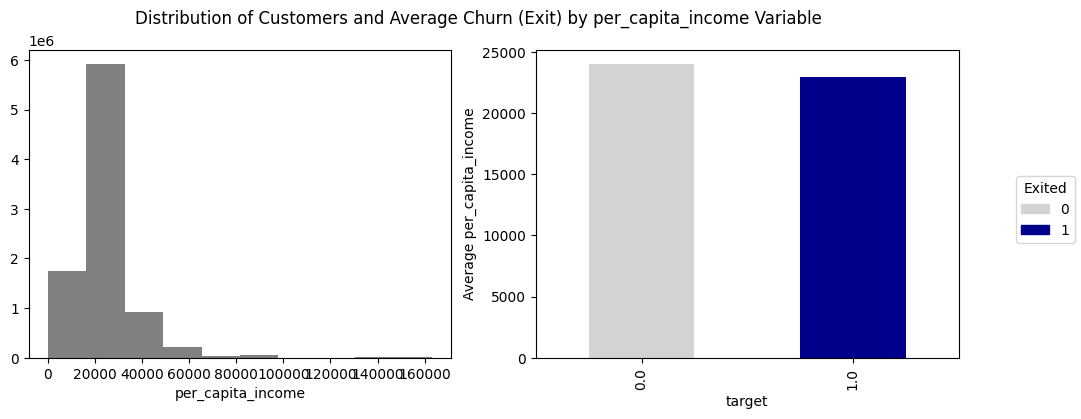

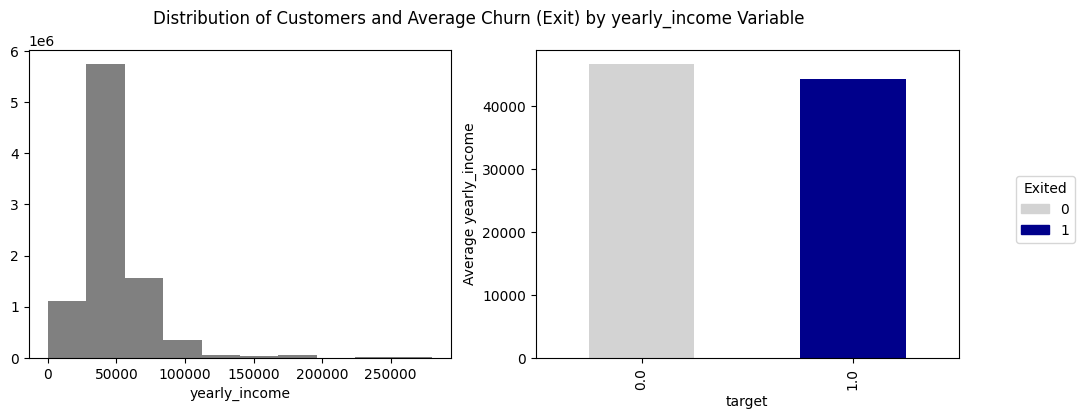

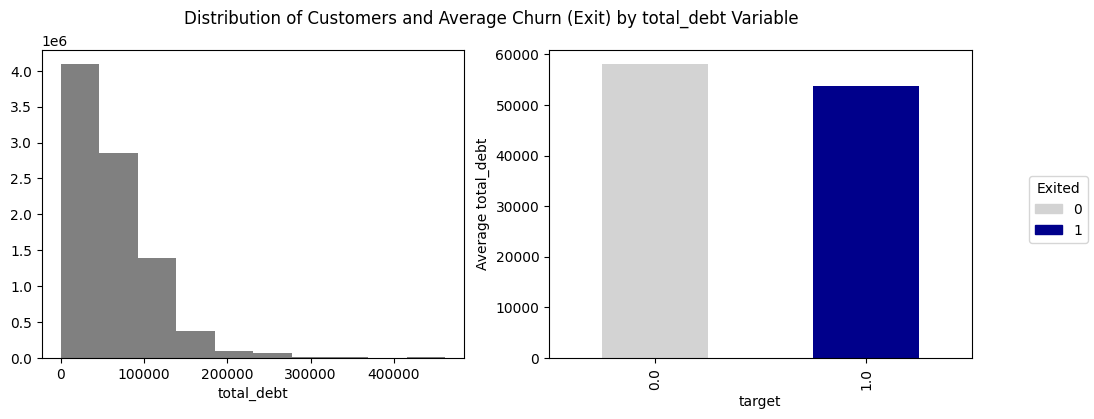

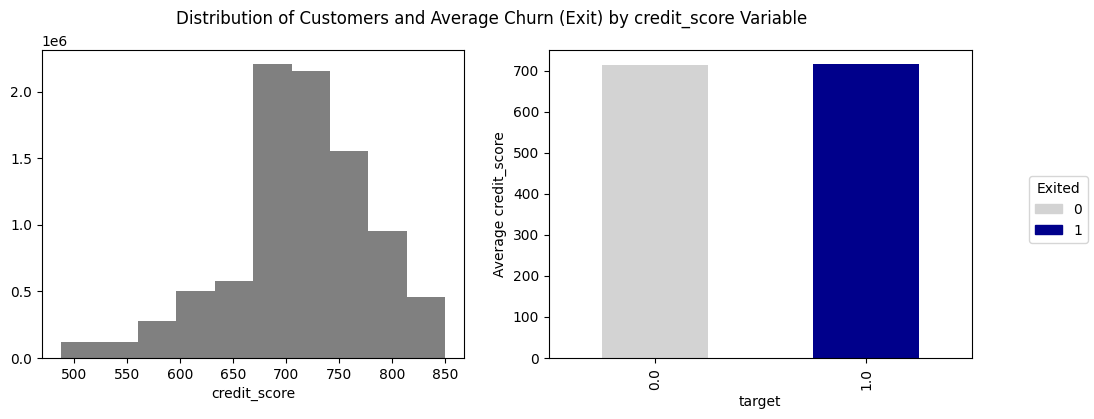

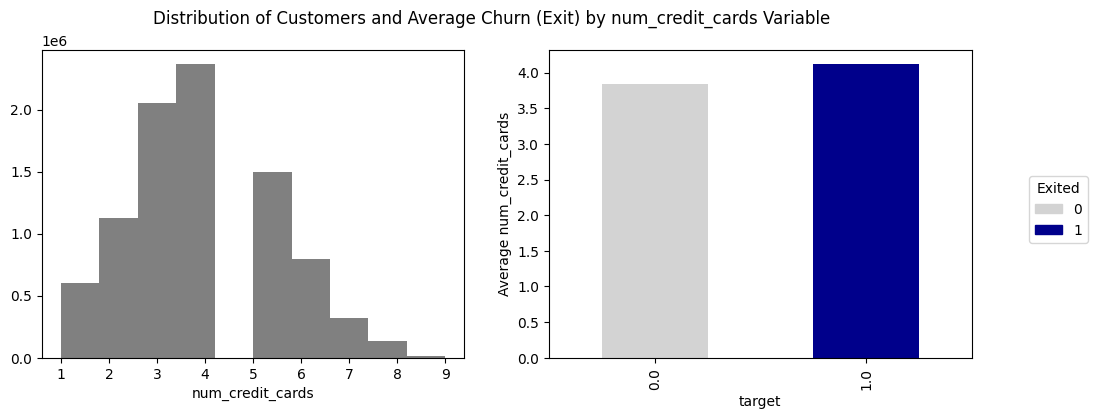

In [8]:
# for each numerical variable
for variable in numerical_cols:
    # set the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Distribution of Customers and Average Churn (Exit) by {variable} Variable')

    # first plot - univariate frequency; include custom x-label
    transactions[variable].hist(grid=False, bins=10, color='grey', ax=axes[0])
    axes[0].set_xlabel(variable)

    # calculate average churn
    stats_values = transactions.groupby(target_column, as_index=False, observed=False)[variable].mean()
    # second plot
    stats_values.plot(x=target_column, y=variable, kind='bar', ax=axes[1], legend=False,
                     color=[target_colors[col] for col in stats_values[target_column]])
    # Labels and title
    axes[1].set_ylabel(f"Average {variable}")
    
    # Add a single legend outside the plots (to the right) for the target legend
    fig.legend(legend_handles, legend_labels, title="Exited", loc='center right')

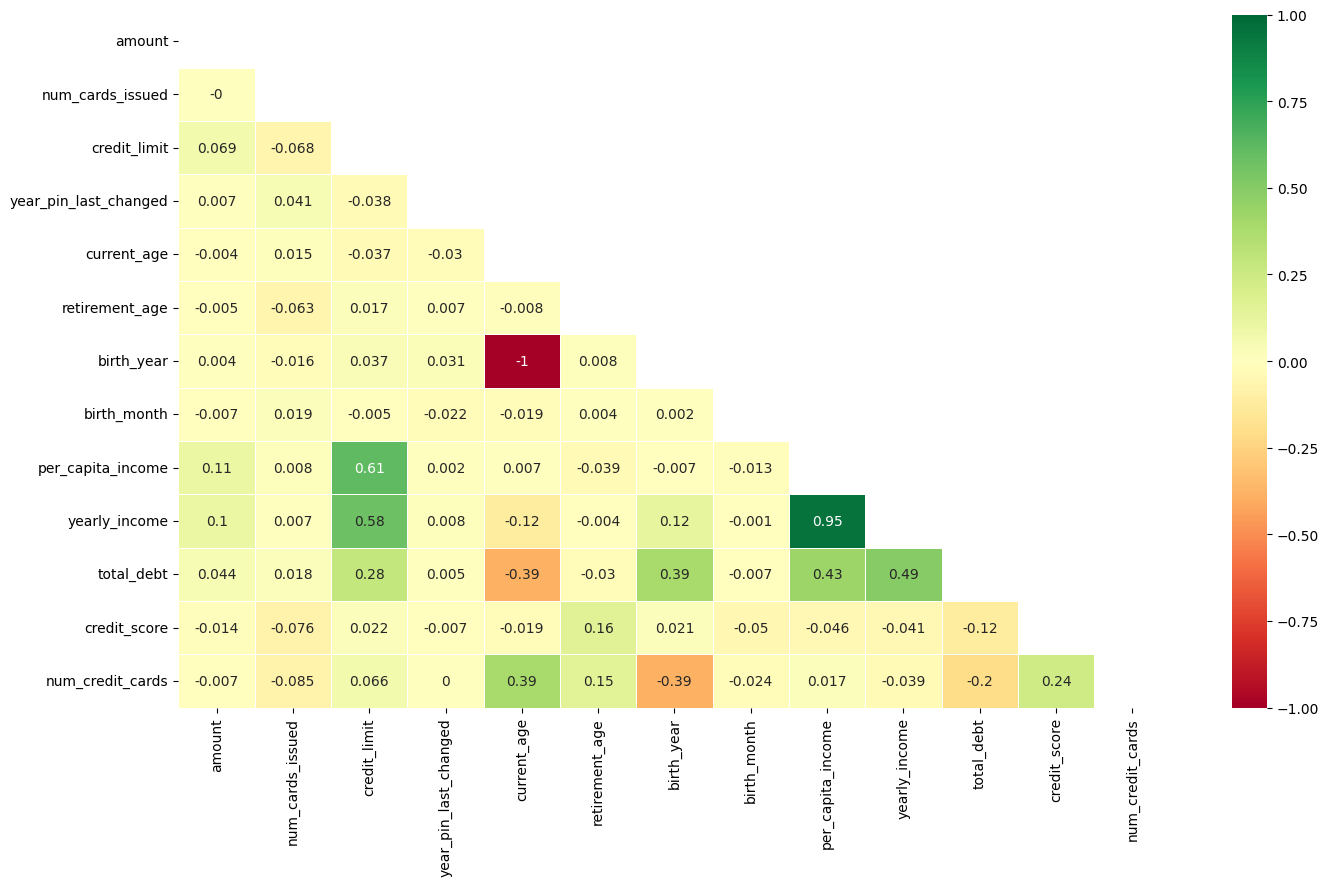

In [9]:
# create correlation matrix
corr_df = transactions[numerical_cols].corr().round(3)
# plot heatmap
f, ax = plt.subplots(figsize=(16, 9))
mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, mask=mask, cmap='RdYlGn', annot=True, vmax=1, vmin=-1, linewidths=.5);

In [10]:
transactions = transactions.drop(columns=['birth_year', 'per_capita_income'])

In [11]:
transactions['merchant_state'] = transactions['merchant_state'].cat.add_categories('Others')
transactions.loc[~transactions['merchant_state'].isin(['Haiti', 'Tuvalu', 'Italy', 'United States']), 'merchant_state'] = 'Others'

In [12]:
category_cols = transactions.select_dtypes(include=['category']).columns.tolist()
numerical_cols = transactions.select_dtypes(include=['number']).columns
date_cols = transactions.select_dtypes(include=['datetime']).columns

In [13]:
transactions['transaction_year'] = transactions['date'].dt.year.astype(int)
transactions['transaction_month'] = transactions['date'].dt.month.astype(int)
transactions['transaction_date'] = transactions['date'].dt.day.astype(int)
transactions['transaction_hour'] = transactions['date'].dt.hour.astype(int)
transactions['transaction_minute'] = transactions['date'].dt.minute.astype(int)
transactions['acct_open_year'] = transactions['acct_open_date'].dt.year.astype(int)
transactions['acct_open_month'] = transactions['acct_open_date'].dt.month.astype(int)
transactions['acct_open_day'] = transactions['acct_open_date'].dt.day.astype(int)
transactions['expires_year'] = transactions['expires'].dt.year.astype(int)
transactions['expires_month'] = transactions['expires'].dt.month.astype(int)
transactions['expires_day'] = transactions['expires'].dt.day.astype(int)
transactions = transactions.drop(columns=['date', 'acct_open_date', 'expires'])

In [20]:
error_dummies = transactions['errors'].str.get_dummies(sep=',')

In [15]:
transactions = pd.concat([transactions, error_dummies], axis=1, ignore_index=False)

In [16]:
transactions.to_csv(f'{input_data_path}/fe_data.csv')